In [1]:
from tqdm import tqdm
from ibapi.client import EClient
from ibapi.common import BarData, TickerId
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

import threading
import time

import pandas as pd
df = pd.read_parquet("US100.parquet")
code_list = list(df.columns)
code_list = [i for i in code_list if i != "US100"]
class IBapi(EWrapper, EClient):
    def __init__(self, code_list):
        EClient.__init__(self, self)
        self.df = []
        self.df_list = []
        self.count = 0
        self.code_list = code_list

    def realtimeBar(self, reqId: int, time: int, open_: float, high: float, low: float, close: float, volume: int, wap: float, count: int):
        return super().realtimeBar(reqId, time, open_, high, low, close, volume, wap, count)
    def position(self, account: str, contract: Contract, position: float, avgCost: float):
        print(account, position)
        self.df.append(position)
        # return super().position(account, contract, position, avgCost)
    
def run_loop():
    app.run()
    
app = IBapi(code_list=code_list)
app.connect('127.0.0.1', 7496, 11)
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()
time.sleep(1)
reqID = 1
app.reqPositions()
app.disconnect()
# for symbol in code_list:
#     print(symbol)
#     apple_contract = Contract()
#     apple_contract.symbol = symbol
#     apple_contract.secType = 'STK'
#     apple_contract.exchange = 'SMART'
#     apple_contract.currency = 'USD'
#     #Request Market Data
#     app.reqHistoricalData(reqID, apple_contract, '', '1 W', '1 min', 'MIDPOINT', True, 1, False, [])
#     reqID += 1


ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usopt
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefnj


In [13]:
df_list = app.df_list
df_list_f = sum(df_list, [])
final = pd.DataFrame(df_list_f)
final.columns = ['da', 'cl', 'code']
pivoted = final.pivot(values='cl', index='da', columns='code')

da
20240819  06:30:00    656.05
20240819  06:31:00    656.08
20240819  06:32:00    656.84
20240819  06:33:00    654.44
20240819  06:34:00    655.63
                       ...  
20240823  12:55:00    621.14
20240823  12:56:00    621.05
20240823  12:57:00    620.29
20240823  12:58:00    620.95
20240823  12:59:00    619.77
Name: INTC, Length: 1950, dtype: float64

In [3]:
from tqdm import tqdm
from ibapi.client import EClient
from ibapi.common import BarData
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

import threading
import time
import pandas as pd
app.disconnect()
df = pd.read_parquet("US100.parquet")
code_list = list(df.columns)
code_list = code_list + []
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.df = []
        self.df_list = []
        self.count = 0

    def historicalData(self, reqId, bar):
        self.df.append([bar.date, bar.close])

    def historicalDataEnd(self, reqId: int, start: str, end: str):
        super().historicalDataEnd(reqId, start, end)  # Call base class implementation
        self.df_list.append(self.df)  # Add collected data to list
        self.df = []
        self.count += 1  # Increment the count of completed requests

def run_loop():
    app.run()
    
app = IBapi()
app.connect('127.0.0.1', 7496, 111)
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()
time.sleep(1)
reqID = 1
for symbol in ['QQQ']:
    print(symbol)
    apple_contract = Contract()
    apple_contract.symbol = symbol
    apple_contract.secType = 'STK'
    apple_contract.exchange = 'SMART'
    apple_contract.currency = 'USD'
    #Request Market Data
    app.reqHistoricalData(reqID, apple_contract, '', '1 W', '1 min', 'MIDPOINT', True, 1, False, [])
    reqID += 1


ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usopt
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefnj


QQQ


In [4]:
qqq = pd.DataFrame(sum(app.df_list, []))
qqq.columns= ['da', 'QQQ']
qqq.set_index('da', inplace=True)
pivoted['QQQ'] = qqq['QQQ']

In [63]:
def backtest_code(code, benchmark = 2):
    rolling = 5
    benchmark_index = "QQQ"
    
    res = pivoted[[code, benchmark_index]]
    pivoted.ffill()
    ret = res.pct_change(fill_method=None)
    try:
        ret['stock_price'] = pivoted[code]
        ret['ret_diff'] = ret[code] - ret[benchmark_index]
        # type 1
        # ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
        # ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
        # ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
        
        # type 2
        ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
        ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
        ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

        ret[code] = pivoted[code]
        ret[benchmark_index] = pivoted[benchmark_index]
        ret['index'] = [i for i in range(len(ret))]

        # check direction

        ret['lag10'] = ret[code].shift(-5)
        ret['lag10_twii'] = ret[benchmark_index].shift(-5)
        ret['change_stock'] = (ret['lag10'] - ret[code])/ret[code]
        ret['change_twii'] = (ret['lag10_twii'] - ret[benchmark_index])/ret[benchmark_index]
        ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
        ret['filter_2'] = ret.apply(lambda x: 0 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)

        # check raise
        ret[f'{code}_lag60'] = ret[code].shift(-60)
        ret['stock_price'] = pivoted[code]
        ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
        ret['target_60mins'] = (np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3)) * ret['direction']
        ret = ret[(ret['stdize_ret_diff'] >= 2) & (ret['filter_1'] == 1) & (ret['filter_2'] == 1)][['target_60mins', 'stdize_ret_diff', 'direction']].dropna()
        
        ret['code'] = code
        
        return ret
    except:
        print(pivoted)

dfs = []
for code in tqdm(list(pivoted.columns)):
    if code == 'QQQ': continue
    df = backtest_code(code)
    if len(df) == 0: continue
    dfs.append(df)

100%|██████████| 97/97 [00:02<00:00, 37.92it/s]


In [64]:
final = pd.concat(dfs)
final['date'] = final.index
final['date'] = final['date'].apply(lambda x: x[0:8])
df_cleaned = final.drop_duplicates(subset=['date', 'code'])

df_cleaned = df_cleaned.drop(columns=['date'])
df_cleaned

code,target_60mins,stdize_ret_diff,direction,code
da,,,,
20240821 06:30:00,0.008,2.922010,-1,ADBE
20240822 06:30:00,0.021,3.985464,-1,BIIB
20240821 06:30:00,0.031,5.331279,-1,DASH
20240820 06:30:00,0.011,2.992912,1,KDP
20240823 06:30:00,0.034,5.846011,-1,KHC
20240822 06:30:00,-0.000,3.854445,-1,LULU
20240821 06:30:00,0.019,12.776524,-1,PANW
20240820 06:30:00,0.033,6.074441,1,PAYX
20240823 06:30:00,0.028,5.407059,-1,PEP


In [65]:
import numpy as np
import pandas as pd
from scipy import stats
# to test if return after 60 mins are greater than {test}
for test in range(0, 15, 1):
    test /= 1000
    final = df_cleaned
    final = final[final['target_60mins'] != 0.0]
    final['target_60mins'] = final['target_60mins'] - test
    mean = final['target_60mins'].mean()
    n = len(final)
    s = final['target_60mins'].std()

    t_statistic = (mean - 0.0) / (s / np.sqrt(n))

    t_stat, p_value = stats.ttest_1samp(final['target_60mins'], 0.0)

    if t_stat > 0:
        one_tailed_p_value = p_value / 2
    else:
        one_tailed_p_value = 1 - (p_value / 2)

    print(f"{test} P-value: {np.round(one_tailed_p_value, 2)} {np.round(t_statistic, 2)}")
print("US100", len(final))
final

0.0 P-value: 0.0 7.47
0.001 P-value: 0.0 7.18
0.002 P-value: 0.0 6.89
0.003 P-value: 0.0 6.6
0.004 P-value: 0.0 6.3
0.005 P-value: 0.0 6.01
0.006 P-value: 0.0 5.72
0.007 P-value: 0.0 5.43
0.008 P-value: 0.0 5.14
0.009 P-value: 0.0 4.85
0.01 P-value: 0.0 4.55
0.011 P-value: 0.0 4.26
0.012 P-value: 0.0 3.97
0.013 P-value: 0.0 3.68
0.014 P-value: 0.0 3.39
US100 10


/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_28210/1779687899.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['target_60mins'] = final['target_60mins'] - test


code,target_60mins,stdize_ret_diff,direction,code
da,,,,
20240821 06:30:00,-0.006,2.922010,-1,ADBE
20240822 06:30:00,0.007,3.985464,-1,BIIB
20240821 06:30:00,0.017,5.331279,-1,DASH
20240820 06:30:00,-0.003,2.992912,1,KDP
20240823 06:30:00,0.020,5.846011,-1,KHC
20240821 06:30:00,0.005,12.776524,-1,PANW
20240820 06:30:00,0.019,6.074441,1,PAYX
20240823 06:30:00,0.014,5.407059,-1,PEP
20240822 06:30:00,0.029,2.420556,-1,REGN


In [67]:
code = 'TSLA'
benchmark_index = "QQQ"
rolling = 10
ret = pivoted[[code, benchmark_index]].pct_change()
ret['ret_diff'] = ret[code] - ret[benchmark_index]
# type 1
# ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
# ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
# ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])

# type 2
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000


ret[code] = pivoted[code]
ret[benchmark_index] = pivoted[benchmark_index]
ret['index'] = [i for i in range(len(ret))]

# check direction

ret['lag10'] = ret[code].shift(-5)
ret['lag10_twii'] = ret[benchmark_index].shift(-5)
ret['change_stock'] = (ret['lag10'] - ret[code])/ret[code]
ret['change_twii'] = (ret['lag10_twii'] - ret[benchmark_index])/ret[benchmark_index]
ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
ret['filter_2'] = ret.apply(lambda x: 0 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-60)
ret['stock_price'] = pivoted[code]
ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
ret['target_60mins'] = (np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3)) * ret['direction']

ret.set_index('index', inplace=True, drop=False)
ret[ret['stdize_ret_diff'] >= 2].head(5)

code,TSLA,QQQ,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,lag10,lag10_twii,change_stock,change_twii,filter_1,filter_2,TSLA_lag60,stock_price,direction,target_60mins
index,,,,,,,,,,,,,,,,,
1560,262.72,478.85,0.127172,0.040290,0.012555,46.178840,1560,262.09,478.58,-0.002398,-0.000564,1,1,255.39,262.72,-1,0.028
1561,263.40,478.33,0.003674,0.040223,0.012793,3.667830,1561,262.05,478.58,-0.005125,0.000523,0,1,255.03,263.40,-1,0.032
1562,261.65,478.35,-0.006686,0.040500,0.012165,7.634700,1562,260.47,478.48,-0.004510,0.000272,0,1,255.19,261.65,-1,0.025
1563,261.90,478.10,0.001478,0.040475,0.012248,4.359119,1563,259.99,478.46,-0.007293,0.000753,0,1,254.75,261.90,-1,0.027
1564,260.94,478.21,-0.003896,0.040525,0.012131,6.494706,1564,259.75,478.69,-0.004560,0.001004,0,1,254.92,260.94,-1,0.023


In [68]:
ret[(ret['stdize_ret_diff'] >= 2) & (ret['filter_1'] == 1) & (ret['filter_2'] == 1)][['target_60mins', 'stdize_ret_diff']].dropna()

code,target_60mins,stdize_ret_diff
index,,
1560,0.028,46.178840
1568,0.020,5.545873
1569,0.019,5.308070


/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_28210/1563646470.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():


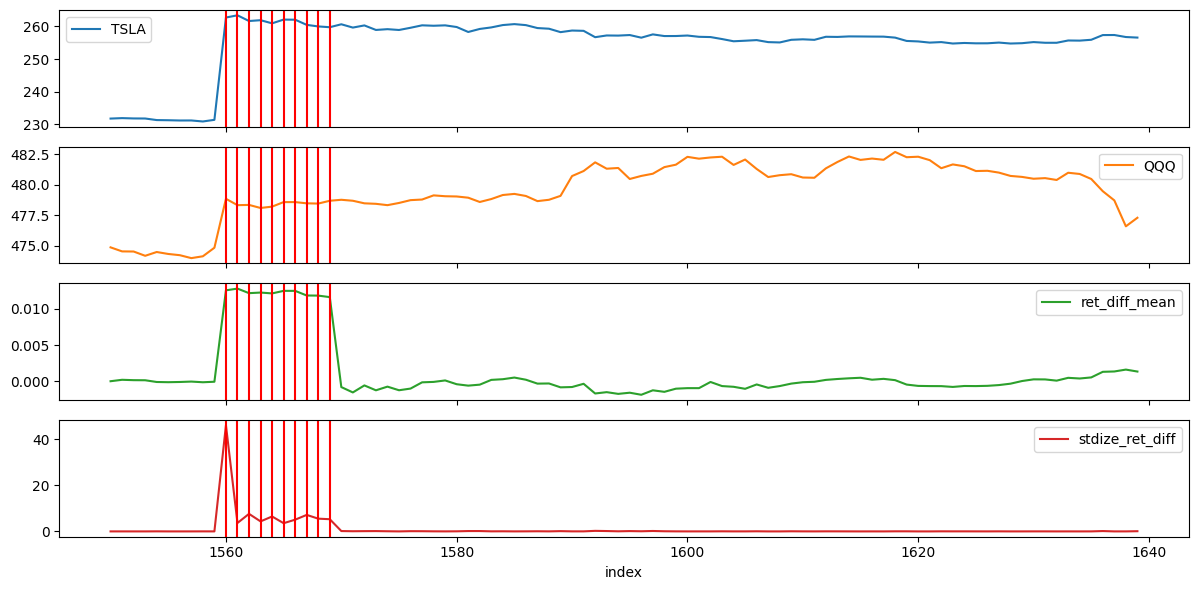

In [70]:
import matplotlib.pyplot as plt
start = 1550
end = len(ret)
end = 1640
bm = 2
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 4, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():  
    for ax in axes:
        ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()